# Import Necessary Library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Dataset

In [7]:
df=pd.read_csv('Imdb_data.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Analyze the dataset for trends, missing values, and outliers.

In [10]:
# Check for missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

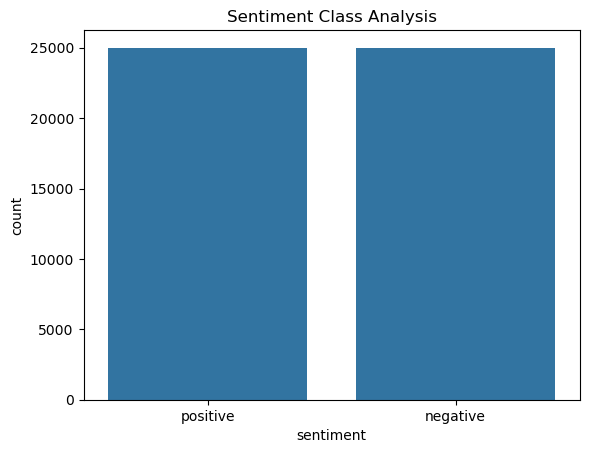

In [12]:
# Identifying imbalanced classes (positive/negative)
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Class Analysis')
plt.show()

In [14]:
# Analyzing the length of reviews
Count_char = df['review'].apply(len)
Count_word = df['review'].apply(lambda x: len(word_tokenize(x)))

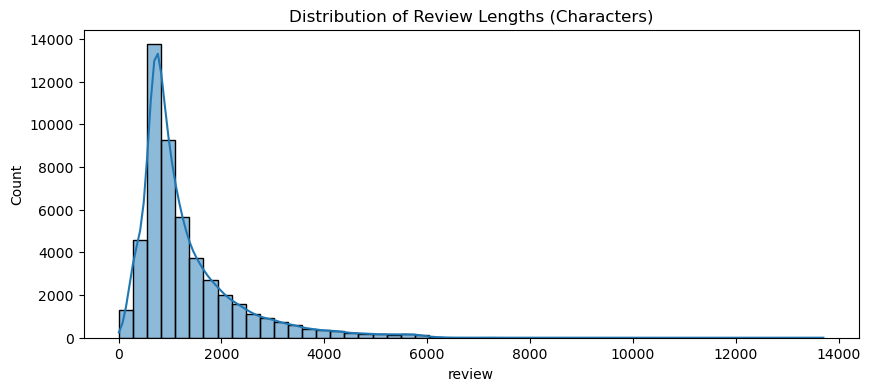

In [15]:
# Plot review lengths
plt.figure(figsize=(10, 4))
sns.histplot(Count_char, bins=50, kde=True)
plt.title('Distribution of Review Lengths (Characters)')
plt.show()

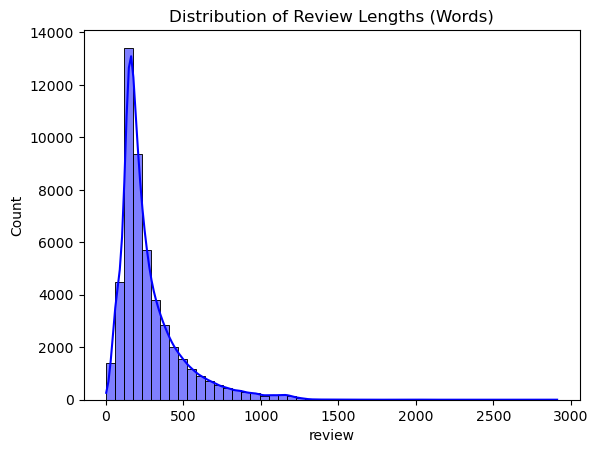

In [18]:
sns.histplot(Count_word, bins=50, kde=True, color='blue')
plt.title('Distribution of Review Lengths (Words)')
plt.show()

# Perform data cleaning and text preprocessing.

In [21]:
def clean_text(text):
    # Lowercase
    text = text.lower()  
    # Remove HTML
    text = re.sub(r'<.*?>', '', text)  
    # Remove punctuation/special chars
    text = re.sub(r'[^a-z\s]', '', text)             
    return text

In [23]:
# Apply cleaning
cleaned_review= df['review'].apply(clean_text)

In [25]:
# Tokenization
tokens=cleaned_review.apply(word_tokenize)

In [26]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens=tokens.apply(lambda x: [word for word in x if word not in stop_words])

In [29]:
# Lemmatization and Stemming
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
lemmatized= tokens.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
stemmed=tokens.apply(lambda x: [stemmer.stem(word) for word in x])

In [32]:
# Join lemmatized tokens into a string for vectorization
lemmatized_text=lemmatized.apply(lambda x: ' '.join(x))
# Bag-of-Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(lemmatized_text)
print("BoW shape:", X_bow.shape)
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(lemmatized_text)
print("TF-IDF shape:", X_tfidf.shape)

BoW shape: (50000, 5000)
TF-IDF shape: (50000, 5000)


# Feature Engineering

In [36]:
#  Feature extraction using techniques like TF-IDF, Word2Vec, or embeddings.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(lemmatized_text)
print("TF-IDF shape:", X_tfidf.shape)  

TF-IDF shape: (50000, 5000)


In [39]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences=lemmatized, vector_size=100, window=5, min_count=2, workers=4)
# Function to average word vectors in a review
def get_avg_w2v(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if not vectors:
        return np.zeros(100)
    return np.mean(vectors, axis=0)
# Apply to entire dataset
X_w2v = np.array(lemmatized.apply(get_avg_w2v).tolist())
print("Word2Vec shape:", X_w2v.shape) 

Word2Vec shape: (50000, 100)


In [41]:
# Textual features: Word count, character count, average word length, etc.
# Word count
Count_word = lemmatized_text.apply(lambda x: len(x.split()))
# Character count
Count_char = lemmatized_text.apply(len)
# Average word length
avg_word_length = Count_char / Count_word

Text(0.5, 1.0, 'Average Word Length')

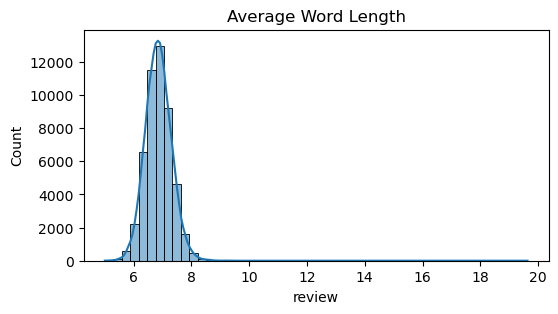

In [43]:
plt.figure(figsize=(6, 3))
sns.histplot(avg_word_length, bins=50, kde=True)
plt.title('Average Word Length')

# Model Development

In [48]:
# Build and train classification models to predict the sentiment of reviews.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Encode sentiment labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])  # 0 = negative, 1 = positive
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [50]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.89      0.88     10000



In [52]:
# Support Vector Machine (SVM)
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred_rf))

Random Forest
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      4961
           1       0.85      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [60]:
from sklearn.metrics import accuracy_score, f1_score

performance_summary = {
    'Model': ['Logistic Regression', 'SVM', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_logreg),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_rf)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_logreg),
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_rf)
    ]
}

import pandas as pd
results_df = pd.DataFrame(performance_summary)
print(results_df)

                 Model  Accuracy  F1 Score
0  Logistic Regression    0.8850  0.887343
1                  SVM    0.8779  0.879953
2        Random Forest    0.8474  0.847735


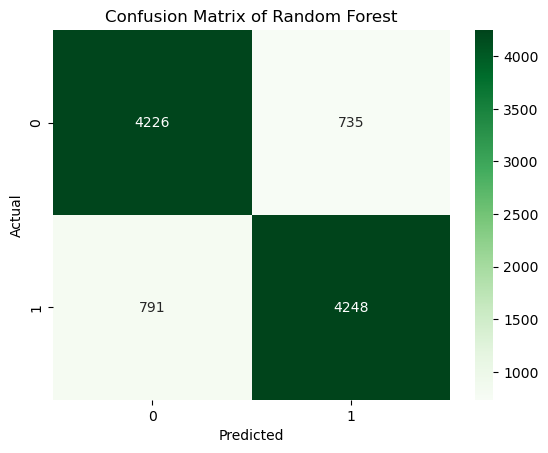

In [74]:
# Confusion Matrix(Random Forest)
from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix of Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

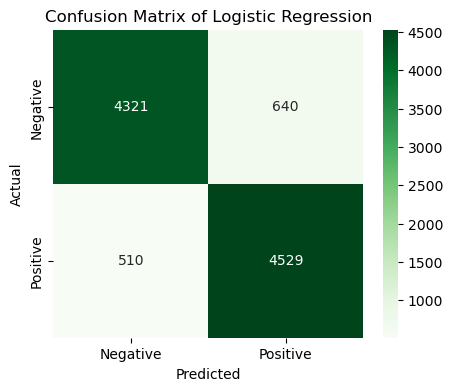

In [76]:
# Confusion Matrix(Logistic Regression)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix of Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

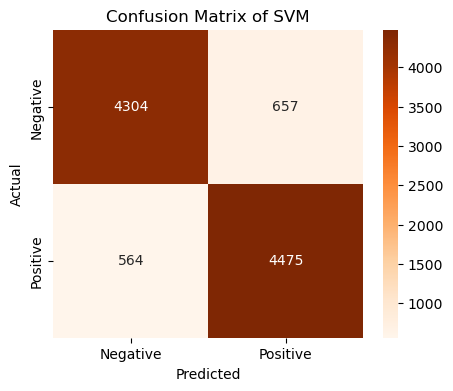

In [78]:
# Confusion Matrix(SVM)
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix of SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
